# Generate data using MITgcm 

### Setup dask 

In [1]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()

options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
# cluster.adapt(5, 200)
cluster.scale(10)
client

[]


KeyboardInterrupt: 

In [1]:
# If wanting to look at local server.
import dask
import distributed

client = distributed.Client()
client

<Client: 'tcp://127.0.0.1:39211' processes=4 threads=8, memory=29.39 GiB>

# Generate some data to train-test-validate on 

Here we generate some data to start developing a CNN to train. 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xgcm
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')

In [3]:
#ds_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'
#ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
# drop variables that have different axis, and not useful for TWA 
#ds = ds.drop_vars(['Eta', 'PH', 'PHL','W']).reset_coords(drop=True)
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
#list(cat)

In [4]:
ds = cat['run_tracers_restored_zarr'].to_dask()
#ds

In [5]:
ds

<xarray.Dataset>
Dimensions:              (YC: 400, XC: 400, time: 1980, Z: 40, Zp1: 41,
                          XG: 400, YG: 400, Zl: 40, Zu: 40,
                          layer_1TH_bounds: 43, layer_1TH_center: 42,
                          layer_1TH_interface: 41)
Coordinates: (12/32)
    Depth                (YC, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    PHrefC               (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF               (Zp1) float32 dask.array<chunksize=(41,), meta=np.ndarray>
  * XC                   (XC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
  * XG                   (XG) float32 0.0 5e+03 1e+04 ... 1.99e+06 1.995e+06
  * YC                   (YC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
    ...                   ...
    maskW                (Z, YC, XG) bool dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    rA                   (YC, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAs                  (YG, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAw                  (YC, XG) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAz                  (YG, XG) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * time                 (time) timedelta64[ns] 61023 days ... 66960 days
Data variables: (12/27)
    Eta                  (time, YC, XC) float32 dask.array<chunksize=(35, 400, 400), meta=np.ndarray>
    PH                   (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    PHL                  (time, YC, XC) float32 dask.array<chunksize=(35, 400, 400), meta=np.ndarray>
    PTRACER01            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    PTRACER02            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    PTRACER03            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    ...                   ...
    PTRACER19            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    PTRACER20            (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    T                    (time, Z, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    U                    (time, Z, YC, XG) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    V                    (time, Z, YG, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>
    W                    (time, Zl, YC, XC) float32 dask.array<chunksize=(35, 1, 400, 400), meta=np.ndarray>

In [6]:
ds = ds.chunk({'time':1})

In [7]:
import sys
sys.path.append('../../modules/')
import filter_coarsen_func as fcf
import MITgcm_advection_schemes as MITadv

In [8]:
#Lfilter = 100e3 
#dx = 5e3
#coarsen_factor = 5
#coarsen_points= int(Lfilter/coarsen_factor/dx)
#coarsen_points
#sigma = Lfilter/dx/(12**0.5)

Lfilter = np.array([400e3, 200e3, 100e3, 50e3] )
dx = 5e3
coarsen_factor = 5
coarsen_points= (Lfilter/coarsen_factor/dx).astype('int')

In [9]:
ds_sel = ds.isel(time=slice(0, 1980, 4))

In [10]:
ds_sel

<xarray.Dataset>
Dimensions:              (YC: 400, XC: 400, time: 495, Z: 40, Zp1: 41, XG: 400,
                          YG: 400, Zl: 40, Zu: 40, layer_1TH_bounds: 43,
                          layer_1TH_center: 42, layer_1TH_interface: 41)
Coordinates: (12/32)
    Depth                (YC, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    PHrefC               (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF               (Zp1) float32 dask.array<chunksize=(41,), meta=np.ndarray>
  * XC                   (XC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
  * XG                   (XG) float32 0.0 5e+03 1e+04 ... 1.99e+06 1.995e+06
  * YC                   (YC) float32 2.5e+03 7.5e+03 ... 1.992e+06 1.998e+06
    ...                   ...
    maskW                (Z, YC, XG) bool dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    rA                   (YC, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAs                  (YG, XC) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAw                  (YC, XG) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    rAz                  (YG, XG) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * time                 (time) timedelta64[ns] 61023 days ... 66951 days
Data variables: (12/27)
    Eta                  (time, YC, XC) float32 dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PH                   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    PHL                  (time, YC, XC) float32 dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PTRACER01            (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    PTRACER02            (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    PTRACER03            (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    ...                   ...
    PTRACER19            (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    PTRACER20            (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    T                    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    U                    (time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    V                    (time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>
    W                    (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 400, 400), meta=np.ndarray>

In [10]:
def add_grads(ds_filt_coarse, Lfilter, coarsen_factor):
    ds_filt_coarse_grads = xr.Dataset()

    dx = Lfilter/coarsen_factor

    grid = xgcm.Grid(ds_filt_coarse, periodic='X')

    # Horizontal gradients
    ds_filt_coarse_grads['Tx'] = grid.interp(grid.diff(ds_filt_coarse['T'], 'X' ),'X')/dx
    ds_filt_coarse_grads['Ty'] = grid.interp(grid.diff(ds_filt_coarse['T'], 'Y', boundary='extend' )
                                             ,'Y', boundary='extend')/dx
    ds_filt_coarse_grads['Ux'] = grid.diff(ds_filt_coarse['U'], 'X' )/dx
    ds_filt_coarse_grads['Uy'] = grid.interp(grid.interp(grid.diff(ds_filt_coarse['U'], 'Y', boundary='extend' )
                                             ,'Y', boundary='extend'), 'X')/dx
    ds_filt_coarse_grads['Vx'] = grid.interp(grid.interp(grid.diff(ds_filt_coarse['V'], 'X' ), 'X'), 
                                             'Y', boundary='extend')/dx
    ds_filt_coarse_grads['Vy'] = grid.diff(ds_filt_coarse['V'], 'Y', boundary='extend')/dx

    # Vertical gradients 
    ds_filt_coarse_grads['Tz'] = grid.interp(grid.diff(ds_filt_coarse['T'], 'Z', boundary='extend' )
                                             ,'Z', boundary='extend')/ds.drF
    ds_filt_coarse_grads['Uz'] = grid.interp(grid.interp(grid.diff(ds_filt_coarse['U'], 'Z', boundary='extend' ),
                                                        'Z', boundary='extend'), 'X')/ds.drF
    ds_filt_coarse_grads['Vz'] = grid.interp(grid.interp(grid.diff(ds_filt_coarse['V'], 'Z', boundary='extend' ), 
                                                        'Z', boundary='extend'),'Y', boundary='extend')/ds.drF
    
    return ds_filt_coarse_grads

In [11]:
ds_all_res_dic = {}
for L in Lfilter: 
    print(L)
    coarsen_point = int(L/coarsen_factor/dx)#.astype('int')
    
    ds_LES = {}
    
    #ds_LES['smooth_vars'] = fcf.coarsen_MITgcm_dataset(fcf.filter_MITgcm_dataset(ds_sel, L, dx, filter_type='gcm_filter'), coarsen_point)
    #ds_LES['full_flux'], ds_LES['LS_flux'], ds_LES['SS_flux'] = fcf.ds_LES_flux_filtered_coarsened(ds_sel,  ds_LES['smooth_vars'], L, dx, coarsen_factor)
    #ds_LES['full_flux_div'], ds_LES['LS_flux_div'], ds_LES['SS_flux_div'] = fcf.ds_LES_flux_div_filtered_coarsened(ds_LES['full_flux'], ds_LES['LS_flux'], ds_LES['SS_flux'], return_components=True)
    
    #ds_all_res_dic[str(int(L/1e3))] = ds_LES
    
    res= str(int(L/1e3))+'/'
    
    ds_all_res_dic[res+'smooth_vars'] = fcf.coarsen_MITgcm_dataset(fcf.filter_MITgcm_dataset(ds_sel, L, dx, filter_type='gcm_filter'), coarsen_point)
    ds_all_res_dic[res+'smooth_vars_grads'] = add_grads(ds_all_res_dic[res+'smooth_vars'], L, coarsen_factor)
    ds_all_res_dic[res+'full_flux'], ds_all_res_dic[res+'LS_flux'], ds_all_res_dic[res+'SS_flux'] = fcf.ds_LES_flux_filtered_coarsened(ds_sel,  ds_all_res_dic[res+'smooth_vars'], L, dx, coarsen_factor)
    ds_all_res_dic[res+'full_flux_div'], ds_all_res_dic[res+'LS_flux_div'], ds_all_res_dic[res+'SS_flux_div'] = fcf.ds_LES_flux_div_filtered_coarsened(
        ds_all_res_dic[res+'full_flux'], ds_all_res_dic[res+'LS_flux'], ds_all_res_dic[res+'SS_flux'], return_components=True)
    

400000.0
200000.0
100000.0


2023-01-26 18:56:34,548 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-26 18:56:43,891 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2023-01-26 18:56:54,824 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


50000.0


2023-01-26 18:57:05,897 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2023-01-26 18:57:17,361 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2023-01-26 18:57:30,747 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


In [19]:
#ds_all_res_dic

In [20]:
#ds_all_res_dic['100/'+'full_flux']

In [21]:
#ds_all_res_dic['100/'+'smooth_vars'].T.isel(time=0, Z=0).plot()

In [16]:
!pip install xarray-datatree -qU;

In [17]:
from datatree import DataTree
ds_all_res = DataTree.from_dict(ds_all_res_dic) 

In [18]:
ds_all_res

DataTree('None', parent=None)
├── DataTree('400')
│   ├── DataTree('smooth_vars')
│   │       Dimensions:  (YC: 25, XC: 25, Z: 40, time: 495, XG: 25, YG: 25, Zl: 40)
│   │       Coordinates: (12/24)
│   │           Depth    (YC, XC) float32 dask.array<chunksize=(25, 25), meta=np.ndarray>
│   │           PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │         * XC       (XC) float32 4e+04 1.2e+05 2e+05 ... 1.8e+06 1.88e+06 1.96e+06
│   │         * YC       (YC) float32 4e+04 1.2e+05 2e+05 ... 1.8e+06 1.88e+06 1.96e+06
│   │         * Z        (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│   │           drF      (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │           ...       ...
│   │           dxG      (YG, XC) float32 dask.array<chunksize=(25, 25), meta=np.ndarray>
│   │           dyC      (YG, XC) float32 dask.array<chunksize=(25, 25), meta=np.ndarray>
│   │           hFacS    (Z, YG, XC) float32 dask.array<chunksize=(1, 25, 25), meta=np.ndarray>
│   │           maskS    (Z, YG, XC) float64 dask.array<chunksize=(1, 25, 25), meta=np.ndarray>
│   │           rAs      (YG, XC) float32 dask.array<chunksize=(25, 25), meta=np.ndarray>
│   │         * Zl       (Zl) float32 0.0 -10.0 -20.0 ... -2.676e+03 -2.779e+03 -2.882e+03
│   │       Data variables:
│   │           T        (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           U        (time, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           V        (time, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           W        (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   ├── DataTree('smooth_vars_grads')
│   │       Dimensions:  (XC: 25, YC: 25, Z: 40, time: 495)
│   │       Coordinates:
│   │         * XC       (XC) float32 4e+04 1.2e+05 2e+05 ... 1.8e+06 1.88e+06 1.96e+06
│   │         * YC       (YC) float32 4e+04 1.2e+05 2e+05 ... 1.8e+06 1.88e+06 1.96e+06
│   │         * Z        (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│   │         * time     (time) timedelta64[ns] 61023 days 61035 days ... 66951 days
│   │           PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │           drF      (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │       Data variables:
│   │           Tx       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Ty       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Ux       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Uy       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Vx       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Vy       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Tz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Uz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   │           Vz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 25, 25), meta=np.ndarray>
│   ├── DataTree('full_flux')
│   │       Dimensions:  (YC: 25, Z: 40, XG: 25, time: 495, XC: 25, YG: 25, Zl: 40)
│   │       Coordinates: (12/23)
│   │         * YC       (YC) float32 4e+04 1.2e+05 2e+05 ... 1.8e+06 1.88e+06 1.96e+06
│   │           drF      (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │           PHrefC   (Z) float32 dask.array<chunksize=(1,), meta=np.ndarray>
│   │         * Z        (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│   │         * XG       (XG) float32 0.0 8e+04 1.6e+05 ... 1.76e+06 1.84e+06 1.92e+06
│   │           rAw      (YC, XG) float32 dask.array<chunksize=(25, 

2023-01-26 18:59:56,950 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


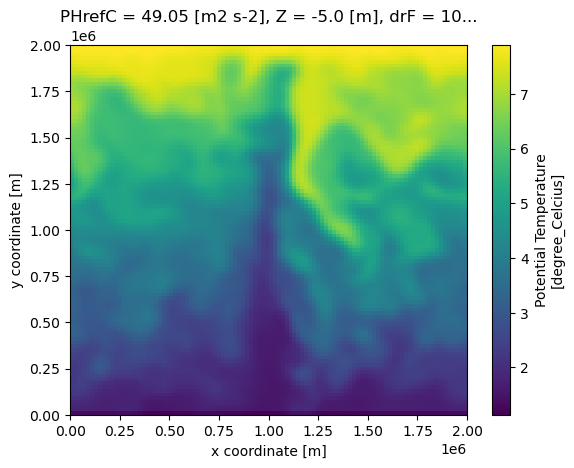

2023-01-26 20:23:52,390 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-01-26 20:23:57,668 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2023-01-26 20:24:02,941 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


In [24]:
ds_all_res['100']['smooth_vars']['T'].isel(time=0, Z=0).plot()

In [19]:
Lkey = '200'
ds_filt_coarse = ds_all_res[Lkey]
ds_ml = xr.merge([ds_filt_coarse['smooth_vars'].to_dataset(), ds_filt_coarse['smooth_vars_grads'].to_dataset(),
                  ds_filt_coarse['SS_flux'].to_dataset(), ds_filt_coarse['SS_flux_div']['Fdiv']]) 


In [20]:
ds_ml = ds_ml.chunk({'XC':-1, 'YC':-1, 'XG':-1, 'YG':-1, 'Z':40, 'Zl': 40, 'time':1}) # choose size to make each chunk about 100mb

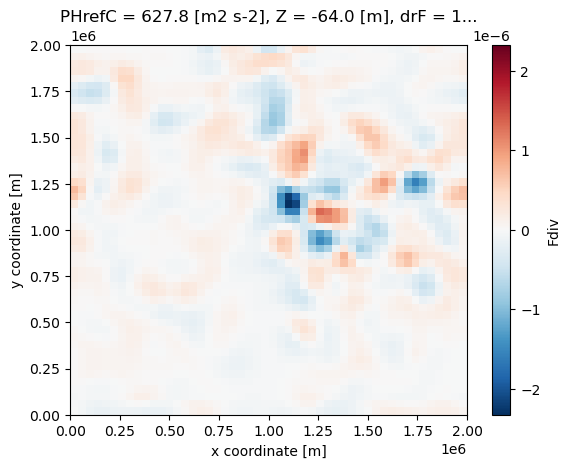

In [21]:
ds_ml['Fdiv'].isel(time=0, Z=5).plot()

In [22]:
import os
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET']
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [23]:
import warnings
warnings.filterwarnings("ignore")

Write out things in a loop: 

In [36]:
fac = 15
len(ds_ml.time)/fac

33.0

In [33]:
len(ds_ml.time)

495

In [37]:
 # how many steps to do the process in. 
for i in range(int(len(ds_ml.time)/fac)):
    print(i)
    if i==0:
        ds_ml.isel(time=slice(i*fac,(i+1)*fac)).to_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_'+Lkey+'km_3D', 
                                                  mode='w')
    else:
        ds_ml.isel(time=slice(i*fac,(i+1)*fac)).to_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_'+Lkey+'km_3D', 
                                                  mode='a', append_dim='time')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [38]:
Lkey

'200'

In [41]:
cluster.shutdown()

#### Try if you can open dataset

In [39]:
temp_50 = xr.open_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_200km_3D')
temp_50

<xarray.Dataset>
Dimensions:  (YC: 50, XC: 50, time: 495, Z: 40, XG: 50, YG: 50, Zl: 40)
Coordinates: (12/24)
    Depth    (YC, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
  * XC       (XC) float32 2e+04 6e+04 1e+05 ... 1.9e+06 1.94e+06 1.98e+06
  * XG       (XG) float32 0.0 4e+04 8e+04 1.2e+05 ... 1.88e+06 1.92e+06 1.96e+06
  * YC       (YC) float32 2e+04 6e+04 1e+05 ... 1.9e+06 1.94e+06 1.98e+06
  * YG       (YG) float32 0.0 4e+04 8e+04 1.2e+05 ... 1.88e+06 1.92e+06 1.96e+06
    ...       ...
    maskS    (Z, YG, XC) float64 dask.array<chunksize=(40, 50, 50), meta=np.ndarray>
    maskW    (Z, YC, XG) float64 dask.array<chunksize=(40, 50, 50), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time     (time) timedelta64[ns] 61023 days 61035 days ... 66951 days
Data variables: (12/17)
    Fdiv     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T        (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    Tx       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    Ty       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    Tz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    U        (time, Z, YC, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    ...       ...
    Vy       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    Vz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    W        (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    uT       (time, Z, YC, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    vT       (time, Z, YG, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    wT       (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>

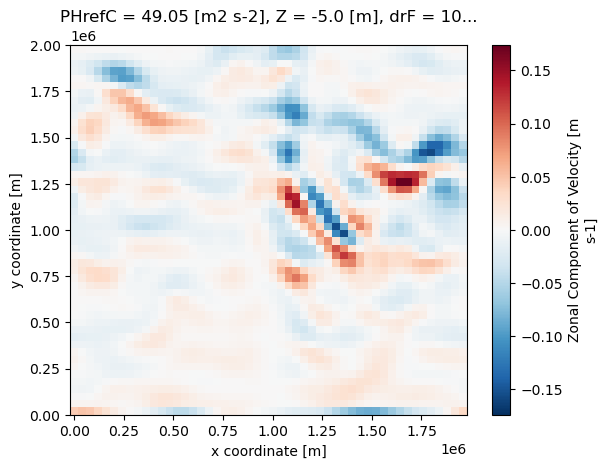

In [40]:
temp_50.uT.isel(time=0, Z=0).plot()

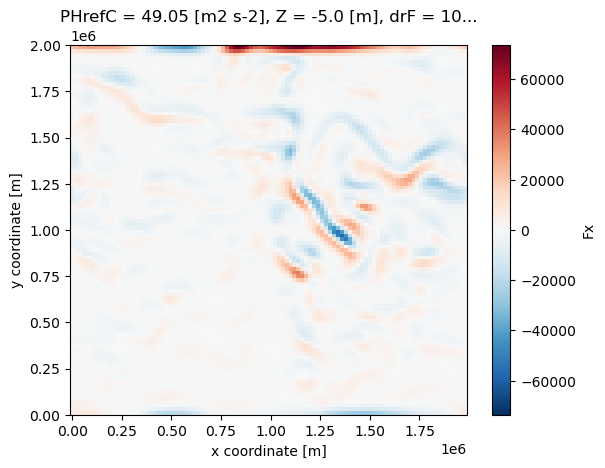

In [31]:
temp_100.Fx.isel(time=0, Z=0).plot()

In [28]:
temp_100 = xr.open_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_100km_3D')
temp_100

<xarray.Dataset>
Dimensions:  (YC: 100, XC: 100, Z: 40, time: 660, XG: 100, YG: 100, Zl: 40)
Coordinates: (12/24)
    Depth    (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
  * XC       (XC) float32 1e+04 3e+04 5e+04 7e+04 ... 1.95e+06 1.97e+06 1.99e+06
  * XG       (XG) float32 0.0 2e+04 4e+04 6e+04 ... 1.94e+06 1.96e+06 1.98e+06
  * YC       (YC) float32 1e+04 3e+04 5e+04 7e+04 ... 1.95e+06 1.97e+06 1.99e+06
  * YG       (YG) float32 0.0 2e+04 4e+04 6e+04 ... 1.94e+06 1.96e+06 1.98e+06
    ...       ...
    maskS    (Z, YG, XC) float64 dask.array<chunksize=(40, 100, 100), meta=np.ndarray>
    maskW    (Z, YC, XG) float64 dask.array<chunksize=(40, 100, 100), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time     (time) timedelta64[ns] 61023 days 61032 days ... 66954 days
Data variables: (12/17)
    F_div    (Z, time, YC, XC) float32 dask.array<chunksize=(40, 1, 100, 100), meta=np.ndarray>
    Fx       (Z, time, YC, XG) float32 dask.array<chunksize=(40, 1, 100, 100), meta=np.ndarray>
    Fy       (Z, time, YG, XC) float32 dask.array<chunksize=(40, 1, 100, 100), meta=np.ndarray>
    Fz       (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    T        (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    Tx       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    ...       ...
    Uz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    V        (time, Z, YG, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    Vx       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    Vy       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    Vz       (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>
    W        (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 100, 100), meta=np.ndarray>

Some scratch code for writing data on the cloud. 

In [1]:
import os

In [9]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET']

In [4]:
import fsspec
gcs = fsspec.filesystem('gcs')

In [34]:
gcs.put('/home/jovyan/2i2c-m2lines/README.md', f'{SCRATCH_BUCKET}/README.md')

[None]

In [10]:
gcs.ls(SCRATCH_BUCKET)

['m2lines-scratch/dhruvbalwada/ML_data',
 'm2lines-scratch/dhruvbalwada/README.md']

In [11]:
gcs.ls(PERSISTENT_BUCKET)

['m2lines-persistent/dhruvbalwada/README.md']

In [12]:
gcs.rm(f'{PERSISTENT_BUCKET}/README.md')